# syasd


In [17]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import seaborn as sns
import polars as pl
from sklearn.cluster import KMeans
from skimage.util import img_as_float

In [12]:
img = cv.imread("ImagemFuzzyCluster01.pgm")
roi = cv.selectROI("segment", img)
cv.destroyAllWindows()

In [13]:
(x, y, w, h) = roi
recorte = img[y:y+h, x:x+w]

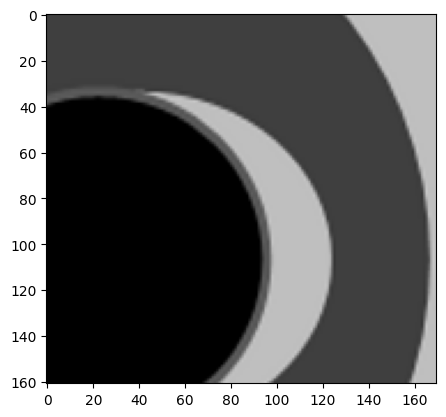

In [14]:

plt.imshow(recorte)

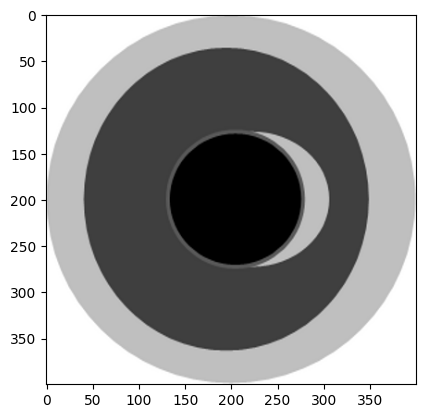

In [15]:
plt.imshow(img)

# Modularizando

In [2]:
from segment import SegmentationHelper

In [3]:
seg = SegmentationHelper()  # agora deve funcionar
seg.read_img("ImagemFuzzyCluster01.pgm")
recorte, img_recorte = seg.roi()


# kmens para segmentação

In [4]:
def calcular_raio_normalizado(imagem: np.ndarray) -> np.ndarray:
    h, w = imagem.shape  # altura e largura da imagem

    # Coordenadas do centro da imagem
    centro_y, centro_x = (h - 1) / 2, (w - 1) / 2

    # Cria um grid com coordenadas (x, y)
    y_indices, x_indices = np.indices((h, w))

    # Calcula a distância euclidiana até o centro
    distancias = np.sqrt((x_indices - centro_x)**2 + (y_indices - centro_y)**2)

    # Normaliza entre 0 e 1
    raio_max = distancias.max()
    distancias_normalizadas = distancias / raio_max if raio_max != 0 else distancias

    return distancias_normalizadas

In [5]:
# atributos
# - Intensidade
# - Distancia ao centro
img = seg.get_img()
radio = calcular_raio_normalizado(np.array(img))
radio = radio.flatten()

df_pl = pl.DataFrame({
    "intensity": img.flatten(),
    "raio": radio
})


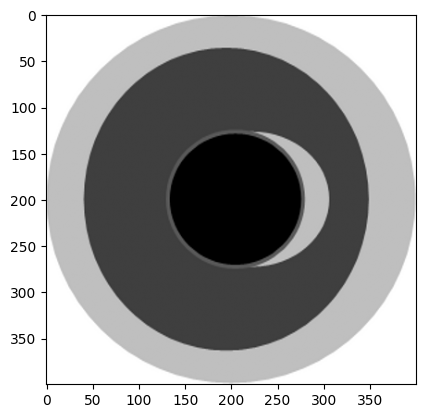

In [7]:
plt.imshow(img, cmap='gray')

<Axes: xlabel='intensity', ylabel='raio'>

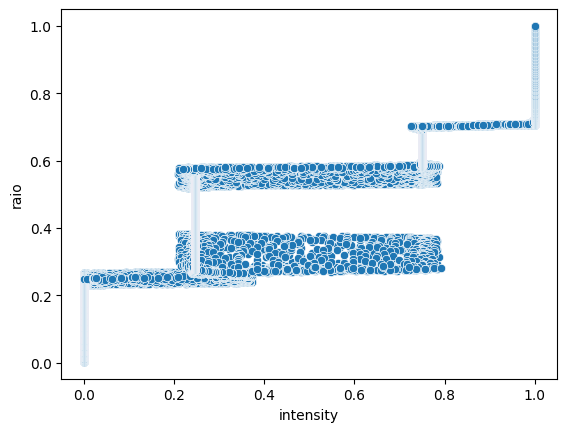

In [8]:
df_pd = df_pl.to_pandas()
sns.scatterplot(data=df_pd, x="intensity", y="raio")

In [54]:
model = KMeans(5)
model.fit(df_pd)

KMeans(n_clusters=5)

In [55]:
y_pred = model.predict(df_pd)
valores_unicos = np.unique(y_pred)
print(valores_unicos)
y_pred = np.where(y_pred == 0, 0, y_pred) 
y_pred = np.where(y_pred == 1, 0, y_pred) 
y_pred = np.where(y_pred == 2, 0, y_pred) 
y_pred = np.where(y_pred == 4, 0, y_pred) 
pred_image = y_pred.reshape(img.shape)

[0 1 2 3 4]


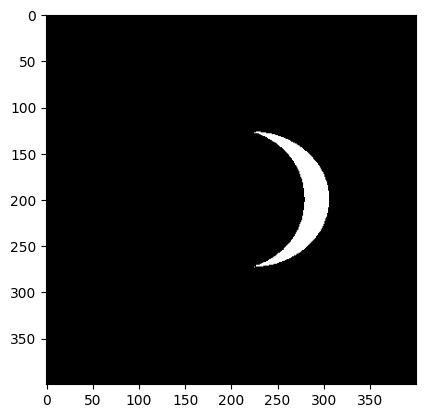

In [56]:
plt.imshow(pred_image, cmap='gray')

# Motor de segmentação

In [75]:
class SegKMens:
    def __init__(self, img):
        self._img = img
        radio = self._radio(np.array(img))
        radio = radio.flatten()

        df_pl = pl.DataFrame({
            "intensity": img.flatten(),
            "raio": radio
        })
        df_pd = df_pl.to_pandas()
        self._df = df_pd

        self._model = KMeans(5)
        self._model.fit(df_pd)

    def _radio(self, img):
        h, w = img.shape  # altura e largura da imagem

        # Coordenadas do centro da imagem
        centro_y, centro_x = (h - 1) / 2, (w - 1) / 2

        # Cria um grid com coordenadas (x, y)
        y_indices, x_indices = np.indices((h, w))

        # Calcula a distância euclidiana até o centro
        distancias = np.sqrt((x_indices - centro_x)**2 + (y_indices - centro_y)**2)

        # Normaliza entre 0 e 1
        raio_max = distancias.max()
        distancias_normalizadas = distancias / raio_max if raio_max != 0 else distancias

        return distancias_normalizadas

    def clusters(self):
        y_pred = self._model.predict(self._df)
        self._y_pred = y_pred
        return np.unique(y_pred)
    
    def run(self, cluster):
        zeros = np.zeros(shape=self._img.shape)
        pred_image = self._y_pred.reshape(self._img.shape)
        pred_image = np.where(pred_image != cluster, 0, pred_image) 
        pred_image = np.where(pred_image == cluster, 1, pred_image) 
        return pred_image + zeros



In [76]:
SKmens = SegKMens(img)
clusters = SKmens.clusters()
print(clusters)

[0 1 2 3 4]


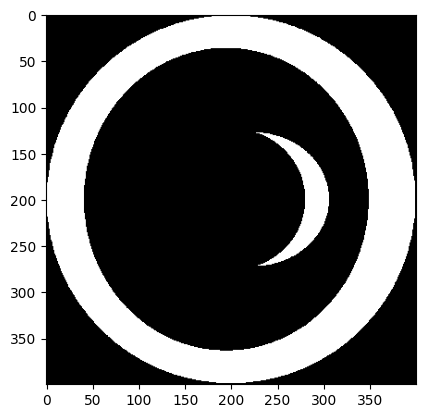

In [84]:
img_seg = SKmens.run(2)
plt.imshow(img_seg,cmap="gray")